In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *

In [2]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1.5
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3, 2.5, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 6, 1, obs_act, 'Obs3')
obs4 = Obstacle(4, 4, 1, obs_act, 'Obs4')
obs5 = Obstacle(6, 7.5, 1, obs_act, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [3]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 1000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 500, 0, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [4]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
# XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
# xs_optimal = XS_Set_optimal[0]
# us_optimal = US_Set_optimal[0]
xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01000e+02  1.01000e+02  3.46624e+01  1.0000  0.00000e+00  9.96889e+00
   2  1.97297e+00  1.97297e+00  2.93912e+00  1.0000  2.68674e-14  2.07698e-01
   3  1.82422e+00  1.82422e+00  1.97332e+00  1.0000  6.31341e-09  3.76220e-02
   4  1.74785e+00  1.74785e+00  1.84444e+00  1.0000  3.83053e-09  3.30103e-02
   5  1.68242e+00  1.68242e+00  2.15743e+00  1.0000  3.94579e-09  5.76472e-02
   6  1.59897e+00  1.59897e+00  6.58760e-01  1.0000  3.78974e-09  1.45284e-01
   7  1.55646e+00  1.55646e+00  2.08065e+01  1.0000  1.17442e-09  1.92219e+00
   8  1.35594e+00  1.35594e+00  1.03916e+01  1.0000  3.97822e-08  4.85074e-01
   9  1.03856e+00  1.03856e+00  7.97573e+00  1.0000  2.19630e-08  4.04185e-02
  10  9.90194e-01  9.90194e-01  1.51426e+00  1.0000  1.13478e-08  5.35122e-03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  9.87136e-01  9.87136e-01  1.05667e-01  1.0000  3.25634e-09  2.6295

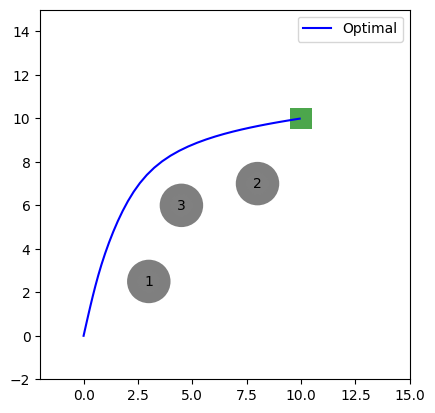

In [5]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [6]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [7]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [8]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, use_factor = False, Lambda = 0.001):
    opt_traj_feat = cost_set.cum_feat(xs_optimal, us_optimal, dt)
    bad_traj_feat = cost_set.cum_feat(np.zeros_like(xs_optimal), np.zeros_like(us_optimal), dt)
    factor = 1/(np.linalg.norm(opt_traj_feat - bad_traj_feat))
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        if use_factor:
            non_opt_traj_feat = cost_set.cum_feat(Xs, Us, dt)
            o = np.exp(factor*np.linalg.norm(opt_traj_feat - non_opt_traj_feat))
            den += np.max([np.nextafter(0,1),o*np.exp(-non_opt_traj_cost)])
        else:
            den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    # output += Lambda*np.linalg.norm(x - w_old)
    return output

def fcn_w_2D(x, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    den += np.exp(-cost_set.traj_cost(xs_non_optimal, us_non_optimal, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [9]:
dt = timeStep
Lambda = 0.001
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
use_factor = True

w0 = w_bad
w_prev = w0
it = 0
max_set_size = 5
# it_max_IRL = max_set_size + 1
it_max_IRL = 50
it_max_sqp = 5

xs = []
us = []
ws = []
Fcns= []
Cost_Diffs = []
W_Diffs = []
Traj_Diffs = []
Opt_Vals = []

xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)

init_choices = ['bad','optimal','previous']
stochastic = False
w_tol = 0.00001
traj_tol = 1e-10
w_diff = 1
traj_diff = 1
e = 1
opt_feat = cost_set.cum_feat(xs_optimal,us_optimal,dt)
non_opt_feat = cost_set.cum_feat(xs_non_optimal, us_non_optimal, dt)
while traj_diff > traj_tol and it < it_max_IRL:
    
    sqp_non_opt = reset_weights(sqp_non_opt, w0[:nr], w0[nr:])
    
    # With simple regulation: ||w||
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, use_factor, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    # # With simple new regulation: ||w - w_old||
    # res = minimize(fcn_w_new, 
    #                w0, 
    #                args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, w_prev, Lambda), 
    #                bounds=bnds, 
    #                method='L-BFGS-B', 
    #                tol = tol,
    #                options=options)
    
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)
    fcn_value = fcn_w(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)
    # fcn_value = 0.0
    Fcns.append(fcn_value)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]

    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy()))
    ws.append(w_loop.copy())
    traj_feat = cost_set.cum_feat(sqp_non_opt.xs.tolist().copy(), sqp_non_opt.us.tolist().copy(), dt)
    # traj_optimality = np.exp(-(np.linalg.norm(opt_feat-traj_feat)))
    # traj_nonoptimality = (np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat))
    optimality = np.exp((np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)))
    Opt_Vals.append(optimality)
    
    if len(xs) <= max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if not stochastic:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
        else:
            xs_non_optimal_set = random.choices(xs, k=max_set_size)
            us_non_optimal_set = random.choices(us, k=max_set_size)
        
    
    opt_diff = (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], dt)- cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], dt))**2 
                
    w_diff = np.linalg.norm(w_loop - w_prev)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2
    Cost_Diffs.append(opt_diff)
    W_Diffs.append(w_diff)
    Traj_Diffs.append(traj_diff)
    if it > 0:
        print('Fcn Value: {:.4f} || Weight Diff: {:.4f} || Traj Diff: {:.4f}, || Optimality: {:.4f}'.format(
            fcn_value, w_diff, traj_diff, optimality
        ))
    
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()
    
    w_prev = w0
    it += 1
    # if it == it_max_IRL-1:
    #     # options['maxiter'] = 200
    #     xs_non_optimal_set = xs
    #     us_non_optimal_set = us

print(res)
w_irl = res.x/np.max(res.x)
# w_irl = ws[ws.index(min(ws))+1]

Fcn Value: 0.0012 || Weight Diff: 0.0000 || Traj Diff: 458.7122, || Optimality: 142.7217
Fcn Value: 0.0012 || Weight Diff: 0.2646 || Traj Diff: 9823.8113, || Optimality: 142.7217
Fcn Value: 0.0012 || Weight Diff: 0.0000 || Traj Diff: 4363.4771, || Optimality: 2.0725
Fcn Value: 0.1731 || Weight Diff: 0.6167 || Traj Diff: 6858.7391, || Optimality: 2.0725
Fcn Value: 0.0394 || Weight Diff: 0.0447 || Traj Diff: 35.9899, || Optimality: 1.6309
Fcn Value: 1.3017 || Weight Diff: 0.2586 || Traj Diff: 2.4383, || Optimality: 1.5262
Fcn Value: 1.6855 || Weight Diff: 0.0003 || Traj Diff: 0.1287, || Optimality: 1.4919
Fcn Value: 3.4249 || Weight Diff: 1.1978 || Traj Diff: 2.7660, || Optimality: 1.5068
Fcn Value: 4.0143 || Weight Diff: 0.5422 || Traj Diff: 0.0002, || Optimality: 1.0370
Fcn Value: 4.1349 || Weight Diff: 0.0881 || Traj Diff: 0.0003, || Optimality: 1.0411
Fcn Value: 4.3141 || Weight Diff: 0.0049 || Traj Diff: 0.4580, || Optimality: 1.0411
Fcn Value: 5.7166 || Weight Diff: 0.0381 || Traj 

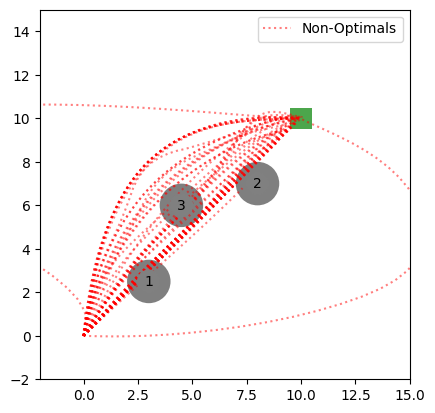

In [10]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [11]:
n = Opt_Vals.index(min(Opt_Vals))
print(n)

9


In [12]:
# w_irl = ws[n+1]
w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0
Terminal ||  Desired:  1.0 IRL:  0.4663997506484662

XReg :
Running ||  Desired:  0.0005 IRL:  0.00030895220502545807
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  1.0 IRL:  0.6293937456337523
Terminal ||  Desired:  0.5 IRL:  0.0

Obs2 :
Running ||  Desired:  1.0 IRL:  0.44297255499509275
Terminal ||  Desired:  0.5 IRL:  0.01902618177328126

Obs3 :
Running ||  Desired:  1.0 IRL:  1.0
Terminal ||  Desired:  0.5 IRL:  0.0



In [13]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

Desired:                  8.312887898484085
IRL:                      12.396662973235246

Desired Trajectory Cost:  0.9871325704160181
with IRL Weight:          0.06270471013341078

IRL Trajectory Cost:      0.183178400141463
with Desired Weight:      1.161424441546044


In [ ]:
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)

10 Trajectories Collected
20 Trajectories Collected
Trajectory 23 Rejected
30 Trajectories Collected
Trajectory 33 Rejected
Trajectory 34 Rejected
40 Trajectories Collected
Trajectory 46 Rejected
Trajectory 47 Rejected
50 Trajectories Collected
60 Trajectories Collected
70 Trajectories Collected
Trajectory 77 Rejected
Trajectory 78 Rejected
80 Trajectories Collected
Trajectory 87 Rejected
90 Trajectories Collected


In [ ]:
print(plot_tested_model(XS_Set, obs_set, target_high))
# print(plot_tested_model(XS_Set_optimal, obs_set, target_high))

In [ ]:
HTML(animateTraj(xs_optimal, xs, obs_set, target_high, sleep=500, animType=2).to_jshtml())

In [ ]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

In [ ]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [ ]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs, us):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [ ]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

In [ ]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()

In [ ]:
# # Add a noisy trajectory to the set
# # scale = 1/traj_diff + 1.0
# scale = 5.0
# noisy_u = np.vstack(sqp_non_opt.us.tolist().copy())+np.random.normal(0.0,scale,np.stack(sqp_non_opt.us.tolist()).shape)
# us.append(noisy_u)
# xs.append(np.stack(problem.rollout([noisy_u[i] for i in range(T)])))